In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [2]:
batch_size = 256

train_dataset = datasets.MNIST('../input/scaetorch/stacked-capsule-networks-master-pytorch/data/', 
                               train=True, 
                               download=False, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('../input/scaetorch/stacked-capsule-networks-master-pytorch/data/', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
print(train_dataset)
print(validation_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../input/scaetorch/stacked-capsule-networks-master-pytorch/data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../input/scaetorch/stacked-capsule-networks-master-pytorch/data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


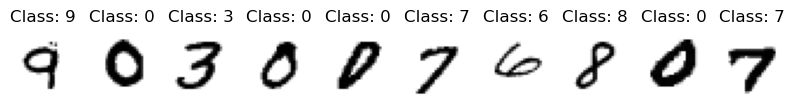

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [8]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data
        target = target

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [9]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data
        target = target
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [10]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304487
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.071974

Validation set: Average loss: 1.9105, Accuracy: 7223/10000 (72%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.964331
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.071476

Validation set: Average loss: 0.8255, Accuracy: 8135/10000 (81%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.944503
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.739868

Validation set: Average loss: 0.5549, Accuracy: 8581/10000 (86%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.699953
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.606561

Validation set: Average loss: 0.4622, Accuracy: 8754/10000 (88%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.586590
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.497440

Validation set: Average loss: 0.4098, Accuracy: 8844/10000 (88%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.547348
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.539636

Validation set: Average loss: 0.3756, Accuracy: 8927/10000 (89%)

Train Epoch: 7 [0/60000 (0%)

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

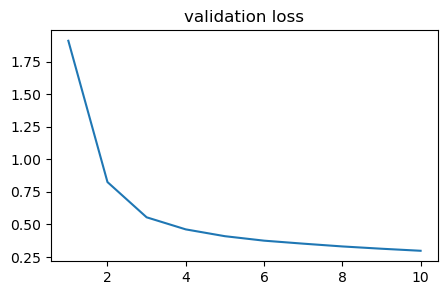

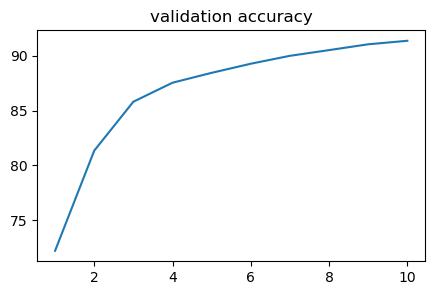

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.

In [4]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.relu(self.fc3(x))
        x = self.fc3_drop(x)# [32, 10]
        return F.log_softmax(self.fc4(x), dim=1)

model = MLPNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75)
criterion = nn.CrossEntropyLoss()

print(model)

MLPNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [6]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [7]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306908
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.135080

Validation set: Average loss: 1.8904, Accuracy: 5334/10000 (53%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.960371
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.679350

Validation set: Average loss: 0.5657, Accuracy: 8360/10000 (84%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.743499
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.444976

Validation set: Average loss: 0.3947, Accuracy: 8867/10000 (89%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.540482
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.512181

Validation set: Average loss: 0.3258, Accuracy: 9059/10000 (91%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.577209
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.309474

Validation set: Average loss: 0.2895, Accuracy: 9153/10000 (92%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.354645
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.327609

Validation set: Average loss: 0.2514, Accuracy: 9242/10000 (92%)

Train Epoch: 7 [0/60000 (0%)

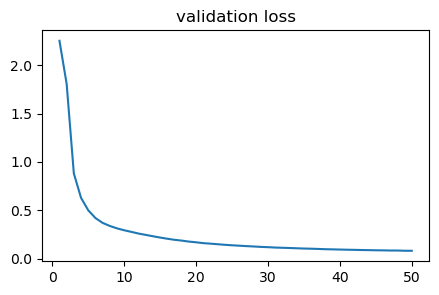

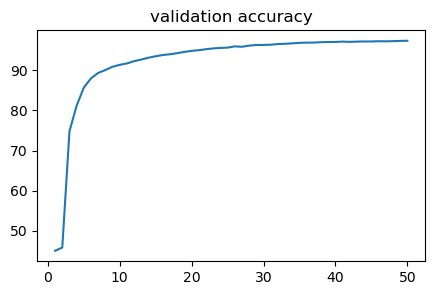

In [19]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

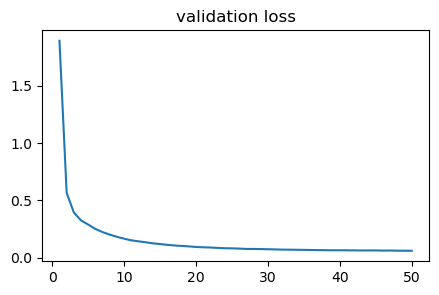

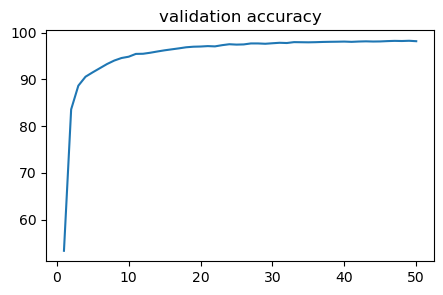

In [8]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

# RESMLP

In [4]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


In [5]:
batch_size = 256

train_dataset = datasets.MNIST('../input/scaetorch/stacked-capsule-networks-master-pytorch/data/', 
                               train=True, 
                               download=False, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('../input/scaetorch/stacked-capsule-networks-master-pytorch/data/', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


In [19]:
# 定义ResMLP模型
class ResMLP(nn.Module):
    def __init__(self):
        super(ResMLP, self).__init__()
        self.in_layer = nn.Linear(28*28, 256)
        self.hidden_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        ) for i in range(5)])
        self.out_layer = nn.Linear(256, 10)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x =  F.relu(self.in_layer(x))
        for layer in self.hidden_layers:
            x = x + layer(x)
        x = self.out_layer(x)
        return x

In [20]:
model = ResMLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75)
criterion = nn.CrossEntropyLoss()

print(model)

ResMLP(
  (in_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (out_layer): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed

        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [11]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [21]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333199
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.355450

Validation set: Average loss: 0.3048, Accuracy: 9111/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.335453
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.287955

Validation set: Average loss: 0.2283, Accuracy: 9334/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.246013
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.202515

Validation set: Average loss: 0.1874, Accuracy: 9427/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.204105
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.203715

Validation set: Average loss: 0.1546, Accuracy: 9510/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.254350
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.076588

Validation set: Average loss: 0.1323, Accuracy: 9591/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.112090
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.101911

Validation set: Average loss: 0.1188, Accuracy: 9629/10000 (96%)

Train Epoch: 7 [0/60000 (0%)

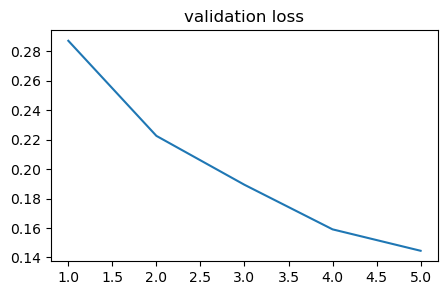

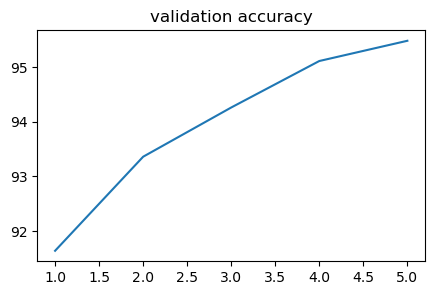

In [13]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

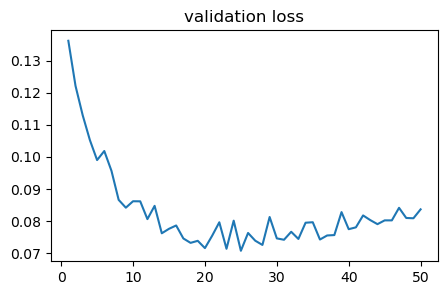

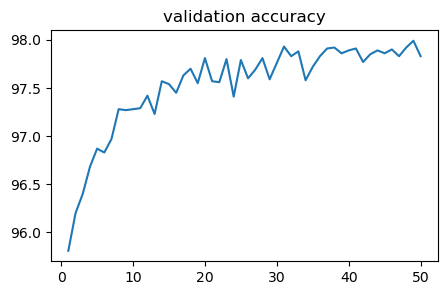

In [15]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

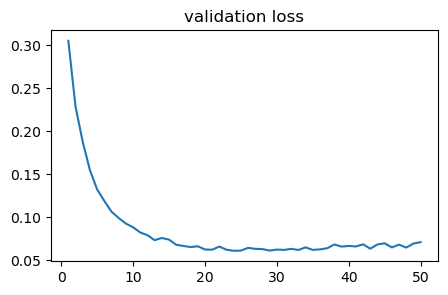

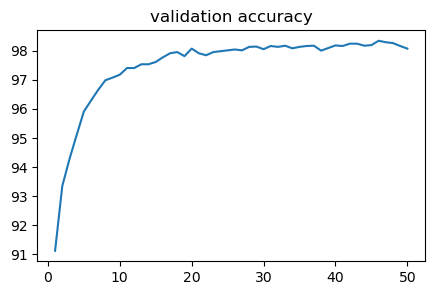

In [22]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [23]:
# 定义ResMLP模型
class ResMLP(nn.Module):
    def __init__(self):
        super(ResMLP, self).__init__()
        self.in_layer = nn.Linear(28*28, 384)
        self.hidden_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(384, 384),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        ) for i in range(4)])
        self.out_layer = nn.Linear(384, 10)


    def forward(self, x):
        x = x.view(-1, 28*28)
        x =  F.relu(self.in_layer(x))
        for layer in self.hidden_layers:
            x = x + layer(x)
        x = self.out_layer(x)
        return x
model = ResMLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75)
criterion = nn.CrossEntropyLoss()

print(model)

ResMLP(
  (in_layer): Linear(in_features=784, out_features=384, bias=True)
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=384, out_features=384, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
  )
  (out_layer): Linear(in_features=384, out_features=10, bias=True)
)


In [24]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335131
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.307950

Validation set: Average loss: 0.3256, Accuracy: 9050/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.367701
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.237888

Validation set: Average loss: 0.2426, Accuracy: 9287/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.256774
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.245785

Validation set: Average loss: 0.2114, Accuracy: 9331/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.219463
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.150959

Validation set: Average loss: 0.1724, Accuracy: 9463/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.189148
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.151483

Validation set: Average loss: 0.1526, Accuracy: 9527/10000 (95%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.150114
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.066927

Validation set: Average loss: 0.1333, Accuracy: 9588/10000 (96%)

Train Epoch: 7 [0/60000 (0%)

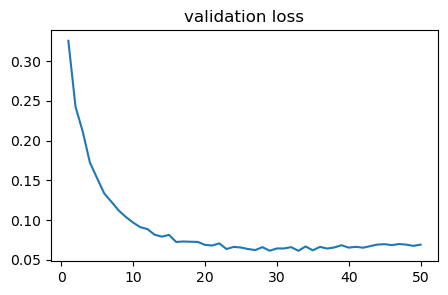

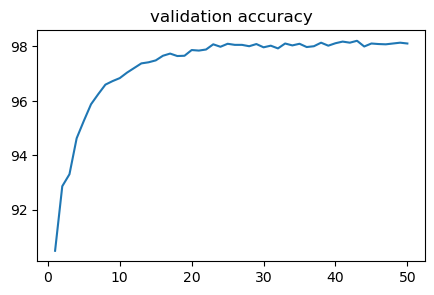

In [25]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');